# Lightweight Transformer-based Model for Handwritten Character Recognition
(https://hal.science/hal-03685976/file/A_Light_Transformer_Based_Architecture_for_Handwritten_Text_Recognition.pdf)

## ***note: Has a CNN backbone***

-----------

## Architecture
Build up with a double Transformer architecture:
- Image transformer as encoder: Extracts the visual features
- Text transformer as decoder: Language modeling, generates word-sections sequence using visual features and previous predictions

### Encoder:
- CNN Backbone (5 convolutions)
- Sinusodial position encoding
- 4 layer transformer layer encoder

### Decoder:
- Takes encoder output and along with sequence of previously predicted characters
- Additional loss in the middle of the network to help convergence

### Hybrid loss:
- CTC and CE Loss combined, CTC on intermediate encoder output, CE on decoder output

--------------


## Start pipeline

In [1]:
import sys
import os

from collections import OrderedDict, Counter

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision as tv
from torchvision.io import read_image

import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

from PIL import Image

import imgaug.augmenters as iaa

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

2023-06-27 16:18:57.329325: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
torch.multiprocessing.set_start_method('spawn', force = True)# good solution !!!!

In [3]:
# pytorch device we want to run the tensor calculations on
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
device

'cpu'

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

### Constants

In [5]:
# DATA_PATH = f"/content/IAM-data/"
DATA_PATH = f"/home/hkolstee/projects/IAM_CNN_transformer/IAM-data/"
TRAIN_TEST_SPLIT = 0.05
# BATCH_SIZE = 4
BATCH_SIZE = 32
INPUT_HEIGHT = 128
# input width -> largest width in batch
#   images max resized and subsequently padded to get to width
EPOCHS = 1500

### Prepare Data

In [6]:
# !unzip -o "/content/drive/MyDrive/IAM-data.zip" -d "/content"

In [7]:
raw_data = pd.read_fwf(DATA_PATH + "iam_lines_gt.txt", header = None)
raw_data = raw_data.values.tolist()
print(len(raw_data))

data = {'img_names': np.squeeze(raw_data[::2]),
        'labels': np.squeeze(raw_data[1::2])}

data = pd.DataFrame(data)
data

14916


,img_names,labels
0,a03-017-07.png,into the pro-communist north and the
1,a03-017-05.png,"to 1958 kept the kingdom in peace, though"
2,a03-017-08.png,pro-western centre and south.
3,a03-017-02.png,in Phnom Penh indicate that he still regards
4,a03-017-06.png,at the cost of virtual partition of the country
...,...,...
7453,d06-000-08.png,fears are based upon completely
7454,d06-000-05.png,"is worrying them, to find the original"
7455,d06-000-09.png,irrational pre-conceived notions - or to
7456,d06-000-02.png,"already suggested, not to be silly or"


an Italian who is perhaps the best Valet de Chambre


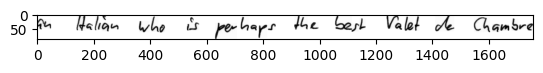

In [8]:
# example (label indx unknown)
ex_label = "an Italian who is perhaps the best Valet de Chambre"
print(ex_label)
image = read_image(os.path.join(DATA_PATH, "img", "g06-026i-01.png"))
plt.imshow(image[0, :, :], cmap = "gray")

first, we need the input/image width we have to resize the images to.
This is the largest image width in the entire batch of images (source paper randomly added/removed new augments each training epoch).
For now we just take the largest width in the original images.

The labels are later padded to the largest label size in the dataset, such that we also need to know the longest label size.

In [9]:
def getBiggestWidth(data: pd.DataFrame):
    biggest_width = 0

    for index in range(len(data['img_names'])):
        image_path = os.path.join(DATA_PATH, "img", data['img_names'][index])
        image = read_image(image_path)

        if (image.size(2) > biggest_width):
            biggest_width = image.size(2)

    return biggest_width

def getLongestLabel(data: pd.DataFrame):
    longest = 0

    for index in range(len(data['labels'])):
        if (len(data['labels'][index]) > longest):
            longest = len(data['labels'][index])

    return longest

Biggest width needed to pad all images to this width for the input into the encoder.
Longest label needed to pad all labels to this length for the input into the decoder.

In [10]:
input_width = getBiggestWidth(data)
print(input_width)

longest_label = getLongestLabel(data)
# <BOS> and <EOS> tokens not counted
longest_label += 2
print(longest_label)

2260
56


### Resize and pad images to largest width in dataset
### ***NOTE: Not sure if padding should be all at the right part of the image or both sides***

In [11]:
# resizes to largest width in batch x 128, keeping aspect ratio and padding image
class resizeImage(object):
    def __init__(self, resize_width, resize_height):
        self.resize_width = resize_width
        self.resize_height = resize_height

    def __call__(self, image):
        # check if resizing to correct height while keeping aspect ratio does not overshoot correct width
        aspect_ratio_width = int((self.resize_height / image.shape[1]) * image.shape[2])
        if (aspect_ratio_width > self.resize_width):
            # calculate max ratio of change for not overshooting resize width while keeping aspect ratio
            max_ratio = self.resize_width / image.shape[2]
            max_resize_height = int(max_ratio * image.shape[1])
            # calc up and down padding
            padding_up = int(((self.resize_height - max_resize_height) / 2))
            padding_down = self.resize_height - max_resize_height - padding_up
            # change resize height to max calculated resize height
            new_resize_height = max_resize_height
        else:
            padding_up = 0
            padding_down = 0
            new_resize_height = self.resize_height

        # resize to correct image height, while keeping aspect ratio
        resize_transform = tv.transforms.Resize((new_resize_height, self.resize_width), antialias = True)

        if isinstance(image, np.ndarray):
          image = resize_transform(torch.tensor(image, dtype = torch.float32))
        else:
          image = resize_transform(image)

        # pad to correct width (and height if necessary)
        padding_left = int(((self.resize_width - image.shape[2]) / 2))
        padding_right = self.resize_width - image.shape[2] - padding_left
        image = F.pad(image, (padding_left, padding_right, padding_up, padding_down), mode = "constant", value = 255)

        return image


This example because it previously overshot the correct width using the height measurements for the aspect ratio.

an Italian who is perhaps the best Valet de Chambre
torch.Size([1, 86, 1758])
torch.Size([1, 128, 2260])
torch.uint8


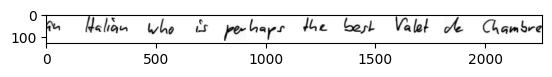

In [12]:
print(ex_label)
image = read_image(os.path.join(DATA_PATH, "img", "g06-026i-01.png"))
print(image.shape)

resize_transform = resizeImage(input_width, INPUT_HEIGHT)
resized_image = resize_transform(image)
plt.imshow(resized_image[0, :, :], cmap = "gray")
print(resized_image.shape)
print(resized_image.dtype)

### Train test split

In [13]:
train_data, test_data = train_test_split(data, test_size = TRAIN_TEST_SPLIT)

# reset indices from current random state
train_data.reset_index(inplace = True)
test_data.reset_index(inplace = True)

print(train_data)

      index        img_names  \
0      4020   p03-087-05.png   
1         8   a03-017-03.png   
2      6935  a01-026x-02.png   
3      3689   a04-003-04.png   
4      2353  c03-003f-01.png   
...     ...              ...   
7080   1125   a02-111-08.png   
7081    567   r03-026-05.png   
7082   5694  g06-045j-04.png   
7083   1617   a05-108-02.png   
7084    868   r06-003-07.png   

                                                 labels  
0                   at the roots and I had a redhead on  
1           himself as the only legal Prime Minister of  
2     been secret negotiations on the Northern Rhode...  
3           clear that he would accept Britain into the  
4                ved throughout in terms of the cinema,  
...                                                 ...  
7080       to deal with the mass sit-down rally planned  
7081   of lovely-ugly to be coldly elegant in. All this  
7082           with extraordinary success in France and  
7083                   But Mr. Heal

### Create custom pytorch dataset


For character level embedding (decoder input) we find out how many characters are present in the dataset. By counting the characters we give the most common characters the lowest indices

In [14]:
# returns a dict of uniques chars sorted on how common they are in the dataset labels
def uniqueCharsByMostCommon(data: pd.DataFrame):
    sortedDict = OrderedDict(Counter(''.join(data['labels'].values)).most_common())
    newDict = {}

    # first add pad, begin of sentence, and end of sentence tokens
    newDict["<PAD>"] = 0
    newDict["<BOS>"] = 1
    newDict["<EOS>"] = 2

    for idx, char in enumerate(sortedDict):
        newDict[char] = idx + 3

    return newDict

In [15]:
# get mapping before splitting dataset
char_to_idx_mapping = uniqueCharsByMostCommon(data)
char_to_idx_mapping

{'<PAD>': 0,
 '<BOS>': 1,
 '<EOS>': 2,
 ' ': 3,
 'e': 4,
 't': 5,
 'a': 6,
 'o': 7,
 'n': 8,
 'i': 9,
 's': 10,
 'r': 11,
 'h': 12,
 'l': 13,
 'd': 14,
 'c': 15,
 'u': 16,
 'm': 17,
 'f': 18,
 'p': 19,
 'w': 20,
 'g': 21,
 'y': 22,
 'b': 23,
 '.': 24,
 ',': 25,
 'v': 26,
 'k': 27,
 "'": 28,
 '"': 29,
 '-': 30,
 'T': 31,
 'I': 32,
 'M': 33,
 'A': 34,
 'S': 35,
 'B': 36,
 'P': 37,
 'H': 38,
 'W': 39,
 'C': 40,
 'N': 41,
 'G': 42,
 'x': 43,
 'R': 44,
 'L': 45,
 'E': 46,
 'D': 47,
 'F': 48,
 '0': 49,
 '1': 50,
 'j': 51,
 'O': 52,
 'q': 53,
 '!': 54,
 'U': 55,
 '(': 56,
 'K': 57,
 '?': 58,
 'z': 59,
 '3': 60,
 ')': 61,
 '9': 62,
 ';': 63,
 'V': 64,
 '2': 65,
 'J': 66,
 'Y': 67,
 ':': 68,
 '5': 69,
 '8': 70,
 '4': 71,
 '6': 72,
 '#': 73,
 '&': 74,
 '7': 75,
 '/': 76,
 'Q': 77,
 'X': 78,
 '*': 79,
 'Z': 80,
 '+': 81}

In [16]:
# Function to calc the mean and std of a dataset to use in image standardization
def calcImagesMeanStd(data):
    running_mean = 0
    running_std = 0

    for image_name in data['img_names']:
        image = read_image(os.path.join(DATA_PATH, "img", image_name)).float()

        mean = torch.mean(image)
        std = torch.std(image)

        running_mean += mean
        running_std += std

    return (running_mean / len(data)), (running_std / len(data))

In [17]:
mean, std = calcImagesMeanStd(data)
mean, std

(tensor(237.3417), tensor(43.9404))

In [18]:
# paper adds gaussian noise to image (sqrt(0.1) * rand from gaussian distri)
class addGaussianNoise(object):
    def __call__(self, image):
        image += ((0.1**0.5) * torch.randn(image.shape)) * 0.75

        return image

In [19]:
class elasticTransform(object):
    def __init__(self):
        self.elastic = iaa.ElasticTransformation(alpha = 800, sigma = 38, mode = "nearest")

    def __call__(self, image):
        image = self.elastic.augment_image(image.squeeze())
        return np.expand_dims(image, 0)

In [20]:
class randomPad(object):
    def __call__(self, image):
        i = np.random.randint(0, 1)
        if i == 0:
            image = np.pad(image.squeeze(), ((0, 0), (np.random.randint(0, 150), 0)), constant_values = 255)
        else:
            image = np.pad(image.squeeze(), ((0, 0), (0, np.random.randint(0, 150))), constant_values = 255)
        return np.expand_dims(image, 0)

In [21]:
class HandWritingDataset(Dataset):
    def __init__(self, eval : bool, data: pd.DataFrame, data_path, img_width, img_height, char_to_idx_mapping: dict, max_label_size, mean, std):
        self.data = data
        self.data_path = data_path
        self.img_width = img_width
        self.img_height = img_height
        self.label_size = max_label_size

        self.char_to_idx_mapping = char_to_idx_mapping
        self.idx_to_char_mapping = {value: key for key, value in self.char_to_idx_mapping.items()}

        # composed transform
        self.transforms_train = tv.transforms.Compose([randomPad(),
                                                       elasticTransform(),
                                                       resizeImage(img_width, img_height),
                                                       tv.transforms.Normalize(mean, std),
                                                       addGaussianNoise()])

        self.transforms_eval = tv.transforms.Compose([resizeImage(img_width, img_height),
                                                      tv.transforms.Normalize(mean, std),
                                                      addGaussianNoise()])

        self.createLabelEncodings()
        self.transformAndStoreImages(eval)

    def createLabelEncodings(self):
        # change character level strings to embed indices
        #   (embedding itself calculated in forward pass)
        self.labels_as_idxs = [torch.tensor([[self.char_to_idx_mapping[char]] for char in label]) for label in self.data['labels']]
        # add <EOS> tokens at the end of sentences
        self.labels_as_idxs = [torch.cat([label, torch.tensor([[self.char_to_idx_mapping['<EOS>']]])]) for label in self.labels_as_idxs]
        # input into decoder shifted right (while training) and <BOS> token inserted at start
        self.decoder_input_as_idxs = [torch.cat([torch.tensor([[self.char_to_idx_mapping['<BOS>']]]), label]) for label in self.labels_as_idxs]

        # target lengths for CTC loss
        # self.labels_lengths = [torch.tensor(len(label)).to(device) for label in self.labels_as_idxs]
        self.labels_lengths = [torch.tensor(len(label)) for label in self.labels_as_idxs]

        # pad labels embedding indices to largest label length with <PAD> token
        self.labels_as_idxs = [F.pad(label, (0, 0, 0, self.label_size - label.shape[0]), mode = 'constant', value = self.char_to_idx_mapping['<PAD>']) \
        # self.labels_as_idxs = [F.pad(label, (0, 0, 0, self.label_size - label.shape[0]), mode = 'constant', value = self.char_to_idx_mapping['<PAD>']).to(device) \
                               for label in self.labels_as_idxs]

        # pad decoder input char embedding indices to largest label length with <PAD> tokens
        self.decoder_input_as_idxs = [F.pad(label, (0, 0, 0, self.label_size - label.shape[0]), mode = 'constant', value = self.char_to_idx_mapping['<PAD>']) \
        # self.decoder_input_as_idxs = [F.pad(label, (0, 0, 0, self.label_size - label.shape[0]), mode = 'constant', value = self.char_to_idx_mapping['<PAD>']).to(device) \
                               for label in self.decoder_input_as_idxs]

        # transform target labels into one hot encoding vectors
        # self.labels_as_onehot =  [F.one_hot(label, num_classes = len(self.char_to_idx_mapping)).squeeze().float() for label in self.labels_as_idxs]
        # self.labels_as_onehot =  [F.one_hot(label, num_classes = len(self.char_to_idx_mapping)).squeeze().float().to(device) for label in self.labels_as_idxs]

    # reshapes + pads the images to the correct input width and height
    def transformAndStoreImages(self, eval):
        self.images = []

        for image_name in self.data['img_names']:
            # read image
            image = read_image(os.path.join(self.data_path, "img", image_name)).float()
            # resize + pad image to correct input size
            if eval:
              image = self.transforms_eval(image)
            else:
              image = self.transforms_train(image)
            # store in list of tensors
            self.images.append(image.to(device))

    # transforms done in __getitem__ so that images can be stored as Byte tensors (-> less memory and kernel does not crash)
    def __getitem__(self, index):
        image = self.images[index]

        # label
        label = self.labels_as_idxs[index].squeeze()
        # decoder_label = self.labels_as_onehot[index]
            # used for CTC Loss
        label_length = self.labels_lengths[index]
        # label shifted right
        decoder_in = self.decoder_input_as_idxs[index].squeeze()

        # image = tensor, label = one hot encoded target characters, decoder_in = label shifted right as indices for embedding table
        # return image, encoder_label, label_length, decoder_label, decoder_in
        
        # image = tensor, label = class indices, label_length = sequence length, decoder_in = label shifted right with <BOS> inserted
        return image, label, label_length, decoder_in

    def __len__(self):
        # return length of column
        return len(self.data)

### Model

Sinusodial positional encoding
(can be changed to nn.embedding layers if we don't get good results, however that is not exactly sinusodial pos encoding like in the paper I think)

<!-- **CHANGED TO NN.EMBEDDING IN MODEL**   -->

In [22]:
class SinPosEncoding(nn.Module):
    def __init__(self, dimensionality):
        super(SinPosEncoding, self).__init__()
        self.dimensionality = dimensionality
        self.max_len = 1000

        # initialize encodings
        pos_encodings = torch.zeros((self.max_len, 1, self.dimensionality), dtype = torch.float32)

        # loop through size of matrix
        for j in range(self.max_len):
            for i in np.arange(int(self.dimensionality / 2)):
                # calc sin and cos wave offsets (alternated) for each row of matrix
                pos_encodings[j, 0, 2*i] = np.sin(j / (self.max_len ** ((2*i) / self.dimensionality)))
                pos_encodings[j, 0, 2*i + 1] = np.cos(j / (self.max_len ** ((2*i) / self.dimensionality)))

        # add to buffer for performance (?)
        self.register_buffer('pos_encodings', pos_encodings)

    def forward(self, input: torch.Tensor):
        # adds the positional encoding elementwise to the tensor (seqlength, batch, embeddims)
        input += self.pos_encodings[0:input.size(0)]

        return input

Model architecture

In [23]:
class CNN(nn.Module):
    def __init__(self, input_height, input_width):
        super(CNN, self).__init__()
        # convolutional block (5 convolutions)
        # first convolution
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3))
        width = input_width - 2
        height = input_height - 2
        self.leakyRelu = nn.LeakyReLU()     # reuse in later layers
        self.maxPool = nn.MaxPool2d((2,2))  # reuse in later layers
        width = int(np.floor(width/2))
        height = int(np.floor(height/2))
        self.layerNorm1 = nn.LayerNorm(normalized_shape = [8, height, width])
        self.dropout = nn.Dropout(0.2)      # reuse in later layers

        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3, 3))
        width -= 2
        height -= 2
        # after maxpool
        width = int(np.floor(width/2))
        height = int(np.floor(height/2))
        self.layerNorm2 = nn.LayerNorm(normalized_shape = [16, height, width])

        # third convolutional layer
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3, 3))
        width -= 2
        height -= 2
        # after maxpool
        width = int(np.floor(width/2))
        height = int(np.floor(height/2))
        self.layerNorm3 = nn.LayerNorm(normalized_shape = [32, height, width])

        # forth convolutional layer
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3))
        width -= 2
        height -= 2
        # no maxpool
        self.layerNorm4 = nn.LayerNorm(normalized_shape = [64, height, width])

        # fifth convolutional layer (kernel size to better match shape of character)
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (4, 2))
        width -= 1
        height -= 3
        # no maxpool
        self.layerNorm5 = nn.LayerNorm(normalized_shape = [128, height, width])

        # following is convolution with width 1 which is used to flatten the current output
        self.flattenConv = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (height, 1))
        self.layerNorm6 = nn.LayerNorm(normalized_shape = [128, 1, width])

        # dense layer to upscale from 128 to 256
        self.dense = nn.Linear(in_features = 128, out_features = 256)

    def forward(self, input_img):
        # first conv
        conv_out = self.layerNorm1(self.maxPool(self.leakyRelu(self.conv1(input_img))))
        conv_out = self.dropout(conv_out)
        # second conv
        conv_out = self.layerNorm2(self.maxPool(self.leakyRelu(self.conv2(conv_out))))
        conv_out = self.dropout(conv_out)
        # third conv
        conv_out = self.layerNorm3(self.maxPool(self.leakyRelu(self.conv3(conv_out))))
        conv_out = self.dropout(conv_out)
        # forth conv
        conv_out = self.layerNorm4(self.leakyRelu(self.conv4(conv_out)))
        # fifth conv
        conv_out = self.layerNorm5(self.leakyRelu(self.conv5(conv_out)))

        # flatten layer
        conv_out = self.layerNorm6(self.leakyRelu(self.flattenConv(conv_out)))

        # reshape from ((batch, 128, 1, x) -> (batch, x, 1, 128)) for dense layer
        conv_out = torch.permute(conv_out, (0, 3, 2, 1))

        # upscale from 128 to 256
        conv_out = self.dense(conv_out)

        # reshape to (seq, batch, embed_dim)
        conv_out = torch.permute(conv_out.squeeze(2), (1, 0, 2))

        return conv_out

In [24]:
class HWRTransformerEncoder(nn.Module):
    def __init__(self, total_nr_of_tokens):
        super(HWRTransformerEncoder, self).__init__()
        # transformer encoder layers (4 stacked transformer encoder layers (4 headed attention))
        self.trans_encoder1 = nn.TransformerEncoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_encoder2 = nn.TransformerEncoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_encoder3 = nn.TransformerEncoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_encoder4 = nn.TransformerEncoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)

        # dense layer for backprop CTC Loss of intermediate encoder result
        self.encoder_out_dense = nn.Linear(256, total_nr_of_tokens)

    def forward(self, encoder_input):
        # transformer encoder layers
        encoder_out = self.trans_encoder1(encoder_input)
        encoder_out = self.trans_encoder2(encoder_out)
        encoder_out = self.trans_encoder3(encoder_out)
        encoder_out = self.trans_encoder4(encoder_out)

        return encoder_out

In [25]:
class HWRTransformerDecoder(nn.Module):
    def __init__(self, total_nr_of_tokens):
        super(HWRTransformerDecoder, self).__init__()

        # batch first = false -> input should be [target_len, batch_size, nr_tokens]
        # transformer decoder layers (4 stacked transformer encoder layers (4 headed attention))
        self.trans_decoder1 = nn.TransformerDecoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_decoder2 = nn.TransformerDecoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_decoder3 = nn.TransformerDecoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_decoder4 = nn.TransformerDecoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)

        # reshape output to number of possible tokens
        self.decoder_out_dense = nn.Linear(256, total_nr_of_tokens)

    def forward(self, decoder_in, encoder_out, target_mask):
        # input encoder output and predicted chars into decoder
        decoder_out = self.trans_decoder1(decoder_in, encoder_out, target_mask)
        decoder_out = self.trans_decoder2(decoder_out, encoder_out, target_mask)
        decoder_out = self.trans_decoder3(decoder_out, encoder_out, target_mask)
        decoder_out = self.trans_decoder4(decoder_out, encoder_out, target_mask)

        # dense layer after decoder to predict one of all tokens (CE Loss)
        decoder_out = self.decoder_out_dense(decoder_out)

        return decoder_out

In [26]:
class HWRTransformer(nn.Module):
    def __init__(self, input_height, input_width, total_nr_of_tokens, longest_label_size):
        super(HWRTransformer, self).__init__()
        # CNN backbone to extract optical features of input image
        self.cnn = CNN(input_height, input_width)

        # pre-encoder positional information
        self.pos_encoding = SinPosEncoding(dimensionality = 256)

        # Transformer encoder
        self.transformer_encoder = HWRTransformerEncoder(total_nr_of_tokens)
        # dense layer and logsoftmax for intermediate output (to backprop with CTC Loss)
        self.encoder_out_dense = nn.Linear(256, total_nr_of_tokens)
        self.encoder_out_logsoftmax = nn.LogSoftmax(dim = 2)

        # character embedding (dim rule of thumb -> 4th sqrt of nr_embeddings: for ~80 = 3)
        #      NOTE: wrong, appearantly dims (encoder output, target embedding) need to be the same
        # <PAD> embedding idx = 0
        self.char_embedding = nn.Embedding(total_nr_of_tokens, 256, padding_idx = 0)

        # Transformer decoder
        self.decoder_target_mask = self.make_target_mask(longest_label_size)
        self.transformer_decoder = HWRTransformerDecoder(total_nr_of_tokens)

    # create a target mask for decoder input
    #   masks the future target characters from being seen by the model before they should
    def make_target_mask(self, size):
        mask = torch.zeros((size, size), dtype = torch.float32).to(device)

        for i in range(size):
            for j in range(size):
                if (j > i):
                    mask[i][j] = float('-inf')
        # print(mask)
        return mask

    def forward(self, input_image, decoder_in_embed_idxs):
        # forward through backbone convolutional neural network
        cnn_out = self.cnn(input_image)

        # add pre-encoder positional information
        cnn_out = self.pos_encoding(cnn_out)

        # forward through transformer encoder
        encoder_out = self.transformer_encoder(cnn_out)

        # print("Encoder out shape:", encoder_out.shape)

        # dense layer for intermediate output (to backprop with CTC Loss).
        # clone, otherwise inplace operation error (compute graph messes up)
        cloned_encoder_out = torch.clone(encoder_out)
        interm_encoder_out = self.encoder_out_logsoftmax(self.encoder_out_dense(cloned_encoder_out))

        # add pre-decoder positional information
        encoder_out = self.pos_encoding(encoder_out)

        # embed character indices for input into decoder
        shifted_target = self.char_embedding(decoder_in_embed_idxs)

        # reshape from (batch, seq_len, embed_dim) -> (seq_len, batch, embed_dim)
        shifted_target = torch.permute(shifted_target, (1, 0, 2))

        # add positional encoding to shifted targets
        shifted_target = self.pos_encoding(shifted_target)

        # forward through transformer decoder
        decoder_out = self.transformer_decoder(shifted_target, encoder_out, self.decoder_target_mask)

        return interm_encoder_out, decoder_out

### Initialize transformer model

In [27]:
hwr_transformer = HWRTransformer(INPUT_HEIGHT, input_width, len(char_to_idx_mapping), longest_label)

# hwr_transformer.load_state_dict(torch.load("/content/drive/MyDrive/model_train22.pth", map_location = torch.device(device)))

# hwr_transformer = hwr_transformer.to(device)

### Define Hybrid Loss


In [60]:
class HybridLoss(nn.Module):
    def __init__(self, balance, nr_of_classes):
        super(HybridLoss, self).__init__()
        # allignment probabilities over encoded input sequence and target sequence
        #   labels are in conform with char to idx mapping (nr of classes - 1 indices)
        #   so I decided to make the blank index the next unused idx mapping
        self.interm_CTCloss = nn.CTCLoss()
        # difference between decodeced input sequence and target sequence.
        # padding index = 0 and should be ignored in loss calculation
        self.output_CELoss = nn.CrossEntropyLoss(ignore_index = 0)

        # balance between CTC Loss and CE Loss (R: [0, 1])
        if balance < 0 or balance > 1:
            raise ValueError("Balance should be a value between 0 (only output CELoss) and 1 (only intermediate CTCLoss)")
        self.balance = balance

    def setBalance(self, balance):
        self.balance = balance

    def forward(self, encoder_outputs, decoder_outputs, labels, label_lengths):
        # create input lengths tensor based on the size of the encoder output
        input_lengths = torch.tensor([encoder_outputs.size(0)]).repeat(encoder_outputs.size(1))

        # cross entropy needs (batch_size, nr_tokens, seq_len), right now its (seq_len, batch_size, nr_tokens)
        # print("decoder_out", decoder_outputs.shape)
        # print("labels", labels.shape)
        decoder_outputs = torch.permute(decoder_outputs, (1, 2, 0))
        # print("decoder_out", decoder_outputs.shape)

        interm_loss = self.interm_CTCloss(encoder_outputs, labels, input_lengths, label_lengths)
        output_loss = self.output_CELoss(decoder_outputs, labels)

        return (self.balance * interm_loss + (1 - self.balance) * output_loss)

In [61]:
# in the paper they only used balance to test efficiousness of the hybrid loss,
#   and train with a balance of 0.5
nr_of_classes = len(char_to_idx_mapping)
print(nr_of_classes)
hybrid_loss_func = HybridLoss(0.5, nr_of_classes)

82


### Train set remade every x epochs with 2000 entries so it can be saved in GPU memory (faster training)

In [39]:
# dataloaders
train_set = HandWritingDataset(False, train_data.sample(500), DATA_PATH, input_width, INPUT_HEIGHT, char_to_idx_mapping, longest_label, mean, std)
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2, pin_memory = True)


# test loader
test_set = HandWritingDataset(True, test_data, DATA_PATH, input_width, INPUT_HEIGHT, char_to_idx_mapping, longest_label, mean, std)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2,  pin_memory = True)

### Test with one image

image tensor shape:
-> torch.Size([1, 128, 2260])
label as idxs shape:
-> torch.Size([56])
label as idxs reversed:
-> ['s', 'a', 'y', 'i', 'n', 'g', '?', '"', ' ', 'J', 'o', 'h', 'n', ' ', 'w', 'a', 's', ' ', 'f', 'u', 'r', 'i', 'o', 'u', 's', '.', ' ', 'T', 'h', 'e', ' ', 'l', 'i', 't', 't', 'l', 'e', ' ', 's', 'q', 'u', 'i', 'r', 't', '!', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
label length:
-> tensor(46)
label shifted right embedding index tensor shape:
-> torch.Size([56])



Shape of output of encoder (CTC Loss):
-> torch.Size([277, 1, 82])
Shape of decoder output (CE Loss):
-> torch.Size([56, 1, 82])

Loss: tensor(12.7501, grad_fn=<AddBackward0>)


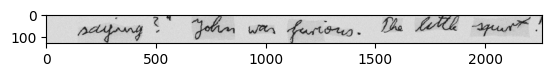

In [62]:
# test image as tensor, test label as one hot encoded target characters, labels shifted right as indices for embedding table
image, label_as_idxs, label_length, label_as_idxs_shifted_right = train_set[0]
# image, label_as_idxs, label_length, test_label_one_hot, label_as_idxs_shifted_right = train_set[0]
# image2, _, _, _, _, = test_set[0]
image2, _, _, _ = test_set[0]


image.to(device)
label_as_idxs.to(device)
label_length.to(device)
# test_label_one_hot.to(device)
label_as_idxs_shifted_right.to(device)

print("image tensor shape:\n->", image.shape)
print("label as idxs shape:\n->", label_as_idxs.shape)
print("label as idxs reversed:\n->", [train_set.idx_to_char_mapping[char.item()] for char in label_as_idxs])
print("label length:\n->", label_length)
# print("one hot label shape:\n->", test_label_one_hot.shape)
print("label shifted right embedding index tensor shape:\n->", label_as_idxs_shifted_right.shape)

# create "batch" with single image
test_image_batch = image.unsqueeze(0)
labels_shifted_right_idxs_batch = label_as_idxs_shifted_right.unsqueeze(0)

# show image
plt.imshow(image[0, :, :].cpu(), cmap = "gray")

# test label = <BOS> *sentence in tokens* <EOS> <PAD> <PAD> ...
out1, out2 = hwr_transformer(test_image_batch.to(device), labels_shifted_right_idxs_batch.to(device))
print("\nShape of output of encoder (CTC Loss):\n->", out1.shape)
print("Shape of decoder output (CE Loss):\n->", out2.shape)

# calculate loss
loss = hybrid_loss_func(out1, out2, label_as_idxs.unsqueeze(0), label_length.unsqueeze(0))
print("\nLoss:", loss)

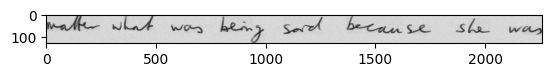

In [63]:
plt.imshow(image2[0, :, :].cpu(), cmap = "gray")

In [ ]:
del train_set, train_loader, test_set, test_loader

### Define optimizer

In [ ]:
optimizer = optim.Adam(hwr_transformer.parameters(), lr = 0.00025)

### Scheduler

In [ ]:
# optimizer warm up
scheduler_warm_up = optim.lr_scheduler.LinearLR(optimizer, start_factor = 1.0, end_factor = 0.9, total_iters = 50)
# scheduler_warm_up = optim.lr_scheduler.LinearLR(optimizer, start_factor = 0.1, end_factor = 1.0, total_iters = 50)
scheduler_decay = optim.lr_scheduler.LinearLR(optimizer, start_factor = 1.0, end_factor = 0.1, total_iters = 500)
# scheduler_decay = optim.lr_scheduler.LinearLR(optimizer, start_factor = 1.0, end_factor = 0.1, total_iters = 750)

### Define train loop

In [ ]:
def train(model, train_data, test_data, loss_func, optim, scheduler_warm_up, scheduler_decay, epochs):
# def train(model, train_data : pd.DataFrame, test_data : pd.DataFrame, loss_func, optim, scheduler_warm_up, scheduler_decay, epochs):
    lowest_train_loss = np.inf
    lowest_test_loss = np.inf
    train_losses = []
    test_losses = []

    # # test dataset / loader
    test_set = HandWritingDataset(True, test_data, DATA_PATH, input_width, INPUT_HEIGHT, char_to_idx_mapping, longest_label, mean, std)
    test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle = True)
    train_set = []
    train_loader = []

    # init tensorboard writer
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter(f"/content/drive/MyDrive/runs/IAM_transformer_{timestamp}")
    # writer = SummaryWriter(f"/home/hkolstee/uniprojects/HWR/IAM_pipelines/runs/IAM_transformer_{timestamp}")

    for epoch in (progress_bar := tqdm(range(epochs))):
        # create new train set every 10 epochs
        if (epoch % 3 == 0):
            # datasets
            del train_set
            train_set = HandWritingDataset(False, train_data.sample(n = 2000, ignore_index = True).drop("index", axis = 1), DATA_PATH, input_width, INPUT_HEIGHT, char_to_idx_mapping, longest_label, mean, std)

            # dataloaders
            del train_loader
            train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True)

        # add epoch info to progress bar
        progress_bar.set_description(f"Epoch {epoch}")

        # reset running losses
        running_loss_train = 0
        running_loss_test = 0

        # train
        model.train(True)
        with torch.autograd.set_detect_anomaly(True):
            for i, data in enumerate(train_loader):
                if i != 0:
                    del images
                    del labels_as_idxs
                    del labels_lengths
                    # del one_hot_labels
                    del labels_as_idxs_shifted_right
                # batched inputs (encoder = images, decoder = labels_shifted_rigth) and labels
                images, labels_as_idxs, labels_lengths, labels_as_idxs_shifted_right = data
                # images, labels_as_idxs, labels_lengths, one_hot_labels, labels_as_idxs_shifted_right = data
                # move data to device
                images = images.to(device)
                labels_as_idxs = labels_as_idxs.to(device)
                labels_lengths = labels_lengths.to(device)
                # one_hot_labels = one_hot_labels.to(device)
                labels_as_idxs_shifted_right = labels_as_idxs_shifted_right.to(device)

                # change one hot labels from (batch, seq_length, nr_tokens) to (seq_length, batch, nr_tokens)
                # one_hot_labels = torch.permute(one_hot_labels, (1, 0, 2))

                # zero gradients before any calculations
                optimizer.zero_grad()

                # predict
                interm_outputs, decoder_outputs = model(images, labels_as_idxs_shifted_right)

                # calc loss
                loss = loss_func(interm_outputs.to(device), decoder_outputs, labels_as_idxs, labels_lengths)
                # print(loss.item())

                # backward pass for gradients
                loss.backward()

                # take step along loss gradients
                optimizer.step()

                # add to running loss
                running_loss_train += loss.item()

            # add to loss value lists
            train_losses.append(running_loss_train / len(train_loader))
            # check if lowest loss
            if (train_losses[-1] < lowest_train_loss):
                lowest_train_loss = train_losses[-1]
                # Save model
                torch.save(model.state_dict(), "drive/MyDrive/model_train" + ".pth")

        # test
        model.eval()
        with torch.no_grad():
            for j, data in enumerate(test_loader):
                # batched inputs (encoder = images, decoder = labels_shifted_rigth) and labels
                if j != 0:
                    del images
                    del labels_as_idxs
                    del labels_lengths
                    del one_hot_labels
                    del labels_as_idxs_shifted_right
                images, labels_as_idxs, labels_lengths, one_hot_labels, labels_as_idxs_shifted_right = data
                labels_as_idxs = labels_as_idxs.to(device)
                labels_lengths = labels_lengths.to(device)
                one_hot_labels = one_hot_labels.to(device)
                labels_as_idxs_shifted_right = labels_as_idxs_shifted_right.to(device)

                # move data to device
                images = images.to(device)

                # change one hot labels from (batch, seq_length, nr_tokens) to (seq_length, batch, nr_tokens)
                one_hot_labels = torch.permute(one_hot_labels, (1, 0, 2))

                # predict
                interm_outputs, decoder_outputs = model(images, labels_as_idxs_shifted_right)

                # calc loss
                loss = loss_func(interm_outputs.to(device), labels_as_idxs, labels_lengths, decoder_outputs, one_hot_labels)

                # add to running loss
                running_loss_test += loss.item()

        # add to loss value lists
        train_losses.append(running_loss_train / len(train_loader))
        test_losses.append(running_loss_test / len(test_loader))

        # learning rate schedulers
        if (epoch < 50):
            scheduler_warm_up.step()
        else:
            scheduler_decay.step()



        # if lowest till now, save model (checkpointing)
        if (test_losses[-1] < lowest_test_loss):
            lowest_test_loss = test_losses[-1]
            torch.save(model.state_dict(), "drive/MyDrive/model_test" + ".pth")



        # before next epoch: add last epoch info to progress bar
        progress_bar.set_postfix({"train_loss": train_losses[-1], "test_loss": test_losses[-1], "lr": scheduler_warm_up.get_last_lr() if epoch < 50 else scheduler_decay.get_last_lr()})

        # save to tensorboard writer
        writer.add_scalars('Training vs. Validation Loss', { 'Training' : train_losses[-1], 'Validation' : test_losses[-1] }, epoch + 1)

    return train_losses, test_losses

### Train the model

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/runs/

In [ ]:
train(hwr_transformer, train_data, test_data, hybrid_loss_func, optimizer, scheduler_warm_up, scheduler_decay, EPOCHS)


Epoch 0:   0%|          | 0/1500 [01:29<?, ?it/s]